**1 — Load the main dataset (df with ClinicalBERT + structured features)**

In [1]:
# Phase5_0: Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

print("Google Drive mounted successfully.")


Mounted at /content/drive
Google Drive mounted successfully.


In [4]:
# ===============================================================
# REBUILD MULTIMODAL DATASET USING CORRECT FILES
# ===============================================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# ===============================================================
# STEP 1 — LOAD STRUCTURED BASE DF
# (RA_COHORT_FINAL — from outputs folder)
# ===============================================================

structured_df_path = "/content/drive/MyDrive/Rahul_DTSC5082_Project/Scenario2_MIMIC/outputs/RA_COHORT_FINAL.csv"

df = pd.read_csv(structured_df_path)
print("Loaded structured dataset:", df.shape)

# Ensure required ID columns exist
assert 'subject_id' in df.columns, "subject_id missing!"
assert 'hadm_id' in df.columns, "hadm_id missing!"

# ===============================================================
# STEP 2 — LOAD CLINICALBERT MEAN-POOL EMBEDDINGS
# ===============================================================

clinicalbert_emb_path = "/content/drive/MyDrive/Rahul_DTSC5082_Project/Scenario2_MIMIC/outputs/RA_NOTES_EMB_ClinicalBERT_meanpool.parquet"

emb = pd.read_parquet(clinicalbert_emb_path)
print("Loaded ClinicalBERT embeddings:", emb.shape)

# Extract embedding columns (should be 768 dims)
cb_cols = [c for c in emb.columns if c.startswith("cb_mean_")]
print("Embedding dimensions found:", len(cb_cols))

# ===============================================================
# STEP 3 — MERGE STRUCTURED DATA + EMBEDDINGS
# ===============================================================

join_keys = ['subject_id', 'hadm_id']
df_merged = df.merge(emb, on=join_keys, how="left")

print("Merged dataset shape:", df_merged.shape)

# Fill missing embeddings with zeros (patients without notes)
df_merged[cb_cols] = df_merged[cb_cols].fillna(0)

# ===============================================================
# STEP 4 — BUILD MULTIMODAL MATRIX (STRUCTURED + EMBEDDINGS)
# ===============================================================

# Structured feature(s)
structured_features = []
if "pain_max" in df_merged.columns:
    structured_features.append("pain_max")

print("Structured features used:", structured_features)

# Scale structured values
if structured_features:
    scaler = StandardScaler()
    X_struct = scaler.fit_transform(df_merged[structured_features].fillna(0))
else:
    X_struct = np.zeros((len(df_merged), 0))  # no structured features

# Embedding matrix
X_emb = df_merged[cb_cols].values

# Final multimodal matrix (should be 769 dims: 1 structured + 768 embed)
X = np.hstack([X_struct, X_emb])

print("Final multimodal X shape:", X.shape)

# ===============================================================
# STEP 5 — DISPLAY PREVIEW
# ===============================================================

df_merged.head()


Loaded structured dataset: (15462, 44)
Loaded ClinicalBERT embeddings: (4979, 771)
Embedding dimensions found: 768
Merged dataset shape: (15462, 813)
Structured features used: ['pain_max']
Final multimodal X shape: (15462, 769)


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,cb_mean_759,cb_mean_760,cb_mean_761,cb_mean_762,cb_mean_763,cb_mean_764,cb_mean_765,cb_mean_766,cb_mean_767,note_id
0,10002443,21329020,2183-10-17 23:20:00,2183-10-20 18:47:00,NaN,EW EMER.,P343TV,TRANSFER FROM HOSPITAL,HOME,Private,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
1,10003203,25146996,2153-04-26 02:05:00,2153-04-29 14:19:00,NaN,EU OBSERVATION,P57BOT,EMERGENCY ROOM,NaN,Medicare,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
2,10010718,29947356,2169-01-20 13:21:00,2169-01-27 14:20:00,NaN,OBSERVATION ADMIT,P50GUR,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
3,10010997,20783870,2139-04-28 16:45:00,2139-05-02 12:20:00,NaN,OBSERVATION ADMIT,P756E2,TRANSFER FROM HOSPITAL,HOME,Private,...,0.068613,-0.290431,-0.107542,0.25966,-0.086897,0.083217,0.208328,-0.113016,-0.178819,10010997-DS-9
4,10010997,20783870,2139-04-28 16:45:00,2139-05-02 12:20:00,NaN,OBSERVATION ADMIT,P756E2,TRANSFER FROM HOSPITAL,HOME,Private,...,0.068613,-0.290431,-0.107542,0.25966,-0.086897,0.083217,0.208328,-0.113016,-0.178819,10010997-DS-9


In [5]:
# Phase5_rebuild_save: Save the final multimodal dataset

output_path = "/content/drive/MyDrive/Rahul_DTSC5082_Project/Scenario2_MIMIC/data/RA_Multimodal_ClinicalBERT_FINAL.csv"

df_merged.to_csv(output_path, index=False)

print("Saved successfully!")
print("File location:")
print(output_path)


Saved successfully!
File location:
/content/drive/MyDrive/Rahul_DTSC5082_Project/Scenario2_MIMIC/data/RA_Multimodal_ClinicalBERT_FINAL.csv


In [6]:
# Phase5_2: Load Triage Data and Merge with Multimodal Dataset

import pandas as pd

# Load final multimodal dataset
mm_path = "/content/drive/MyDrive/Rahul_DTSC5082_Project/Scenario2_MIMIC/data/RA_Multimodal_ClinicalBERT_FINAL.csv"
df_mm = pd.read_csv(mm_path)
print("Multimodal DF:", df_mm.shape)

# Load triage table
triage_path = "/content/drive/MyDrive/Rahul_DTSC5082_Project/Scenario2_MIMIC/data/triage.csv"
triage = pd.read_csv(triage_path)
print("Triage DF:", triage.shape)

# Inspect triage columns
print("\nTriage Columns:", triage.columns.tolist())
triage.head()


Multimodal DF: (15462, 813)
Triage DF: (425087, 11)

Triage Columns: ['subject_id', 'stay_id', 'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity', 'chiefcomplaint']


,subject_id,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint
0,10000032,32952584,97.8,87.0,14.0,97.0,71.0,43.0,7,2.0,Hypotension
1,10000032,33258284,98.4,70.0,16.0,97.0,106.0,63.0,0,3.0,"Abd pain, Abdominal distention"
2,10000032,35968195,99.4,105.0,18.0,96.0,106.0,57.0,10,3.0,"n/v/d, Abd pain"
3,10000032,38112554,98.9,88.0,18.0,97.0,116.0,88.0,10,3.0,Abdominal distention
4,10000032,39399961,98.7,77.0,16.0,98.0,96.0,50.0,13,2.0,"Abdominal distention, Abd pain, LETHAGIC"


In [7]:
# Phase5_3: Clean triage acuity + create 3-level urgency classes

triage_clean = triage.copy()

# Keep only the needed columns
triage_clean = triage_clean[['subject_id', 'stay_id', 'acuity']]

# Remove rows where acuity is missing
triage_clean = triage_clean.dropna(subset=['acuity'])

# Convert acuity to int
triage_clean['acuity'] = triage_clean['acuity'].astype(int)

# Map acuity → urgency
def map_urgency(a):
    if a == 1:
        return "Critical"
    elif a in [2, 3]:
        return "Moderate"
    else:
        return "Low"

triage_clean['urgency'] = triage_clean['acuity'].apply(map_urgency)

print("Triage cleaned:", triage_clean.shape)
triage_clean.head()


Triage cleaned: (418100, 4)


,subject_id,stay_id,acuity,urgency
0,10000032,32952584,2,Moderate
1,10000032,33258284,3,Moderate
2,10000032,35968195,3,Moderate
3,10000032,38112554,3,Moderate
4,10000032,39399961,2,Moderate


In [8]:
# Phase5_4: Merge triage -> edstays -> multimodal dataset

import pandas as pd

# Load multimodal dataset
mm_path = "/content/drive/MyDrive/Rahul_DTSC5082_Project/Scenario2_MIMIC/data/RA_Multimodal_ClinicalBERT_FINAL.csv"
df_mm = pd.read_csv(mm_path)
print("Multimodal DF:", df_mm.shape)

# Load triage cleaned
triage_clean = triage_clean  # from previous step

# Load ED stays (mapping from stay_id -> hadm_id)
edstays_path = "/content/drive/MyDrive/Rahul_DTSC5082_Project/Scenario2_MIMIC/data/edstays.csv"
ed = pd.read_csv(edstays_path)
print("ED stays DF:", ed.shape)
print(ed.columns.tolist())

# --- Step 1: Merge triage with ED stays on stay_id ---
triage_ed = triage_clean.merge(ed[['stay_id', 'hadm_id']], on='stay_id', how='left')

print("After merging triage with ED stays:", triage_ed.shape)

# --- Step 2: Merge result with multimodal df on hadm_id ---
df_final = df_mm.merge(triage_ed[['hadm_id', 'urgency']], on='hadm_id', how='left')

print("Final DF with urgency:", df_final.shape)

# Check urgency distribution
print(df_final['urgency'].value_counts(dropna=False))
df_final.head()


Multimodal DF: (15462, 813)
ED stays DF: (425087, 9)
['subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime', 'gender', 'race', 'arrival_transport', 'disposition']
After merging triage with ED stays: (418100, 5)
Final DF with urgency: (15469, 814)
urgency
NaN         12110
Moderate     3058
Critical      279
Low            22
Name: count, dtype: int64


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,cb_mean_760,cb_mean_761,cb_mean_762,cb_mean_763,cb_mean_764,cb_mean_765,cb_mean_766,cb_mean_767,note_id,urgency
0,10002443,21329020,2183-10-17 23:20:00,2183-10-20 18:47:00,NaN,EW EMER.,P343TV,TRANSFER FROM HOSPITAL,HOME,Private,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
1,10003203,25146996,2153-04-26 02:05:00,2153-04-29 14:19:00,NaN,EU OBSERVATION,P57BOT,EMERGENCY ROOM,NaN,Medicare,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
2,10010718,29947356,2169-01-20 13:21:00,2169-01-27 14:20:00,NaN,OBSERVATION ADMIT,P50GUR,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
3,10010997,20783870,2139-04-28 16:45:00,2139-05-02 12:20:00,NaN,OBSERVATION ADMIT,P756E2,TRANSFER FROM HOSPITAL,HOME,Private,...,-0.290431,-0.107542,0.25966,-0.086897,0.083217,0.208328,-0.113016,-0.178819,10010997-DS-9,Moderate
4,10010997,20783870,2139-04-28 16:45:00,2139-05-02 12:20:00,NaN,OBSERVATION ADMIT,P756E2,TRANSFER FROM HOSPITAL,HOME,Private,...,-0.290431,-0.107542,0.25966,-0.086897,0.083217,0.208328,-0.113016,-0.178819,10010997-DS-9,Moderate


In [9]:
# Phase5_5: Prepare final dataset for triage prediction

df_triage = df_final.copy()

# Keep only rows with valid urgency labels
df_triage = df_triage.dropna(subset=['urgency'])

print("Rows with valid triage labels:", df_triage.shape)

# Encode urgency into numeric labels
urgency_map = {"Critical": 2, "Moderate": 1, "Low": 0}
df_triage['urgency_code'] = df_triage['urgency'].map(urgency_map)

print("\nUrgency class counts:")
print(df_triage['urgency'].value_counts())

print("\nEncoded labels counts:")
print(df_triage['urgency_code'].value_counts())

df_triage[['urgency', 'urgency_code']].head()


Rows with valid triage labels: (3359, 814)

Urgency class counts:
urgency
Moderate    3058
Critical     279
Low           22
Name: count, dtype: int64

Encoded labels counts:
urgency_code
1    3058
2     279
0      22
Name: count, dtype: int64


,urgency,urgency_code
3,Moderate,1
4,Moderate,1
10,Moderate,1
17,Critical,2
21,Moderate,1


In [10]:
# Phase5_6: Build final X (multimodal) and y (urgency labels)

import numpy as np

df_model = df_triage.copy()

# Identify embedding columns
cb_cols = [c for c in df_model.columns if c.startswith("cb_mean_")]
cb_cols = sorted(cb_cols)  # ensure correct order

print("Embedding dimensions:", len(cb_cols))

# ------------------------------
# Structured feature(s)
# ------------------------------
structured_features = ["pain_max"]

# Scale structured features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_struct = scaler.fit_transform(df_model[structured_features].fillna(0))

print("Structured X shape:", X_struct.shape)

# ------------------------------
# Embedding matrix
# ------------------------------
X_emb = df_model[cb_cols].values

print("Embedding X shape:", X_emb.shape)

# ------------------------------
# Final multimodal matrix
# ------------------------------
X_final = np.hstack([X_struct, X_emb])

print("Final X shape:", X_final.shape)   # Expect ~ (3359, 769)

# ------------------------------
# Labels (y)
# ------------------------------
y_final = df_model["urgency_code"].values
print("y shape:", y_final.shape)
print("Unique labels:", np.unique(y_final))


Embedding dimensions: 768
Structured X shape: (3359, 1)
Embedding X shape: (3359, 768)
Final X shape: (3359, 769)
y shape: (3359,)
Unique labels: [0 1 2]


In [12]:
# Phase5_7_Fix: Train XGBoost Triage Model (CPU hist version)

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# ------------------------------------
# Train-test split (same as before)
# ------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.20, random_state=42, stratify=y_final
)

# ------------------------------------
# DMatrix
# ------------------------------------
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# ------------------------------------
# XGBoost parameters (CPU optimized)
# ------------------------------------
params = {
    "objective": "multi:softprob",
    "num_class": 3,
    "tree_method": "hist",        # CPU-optimized
    "max_depth": 10,
    "eta": 0.05,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "eval_metric": "mlogloss",
    "lambda": 1.0
}

# ------------------------------------
# Train model
# ------------------------------------
evals = [(dtrain, "train"), (dtest, "test")]
model = xgb.train(params, dtrain, num_boost_round=400, evals=evals, verbose_eval=50)

# ------------------------------------
# Predict
# ------------------------------------
y_pred_probs = model.predict(dtest)
y_pred = np.argmax(y_pred_probs, axis=1)

# ------------------------------------
# Evaluation
# ------------------------------------
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


[0]	train-mlogloss:0.65445	test-mlogloss:0.65977
[50]	train-mlogloss:0.12146	test-mlogloss:0.28075
[100]	train-mlogloss:0.06276	test-mlogloss:0.29032
[150]	train-mlogloss:0.05159	test-mlogloss:0.31453
[200]	train-mlogloss:0.04797	test-mlogloss:0.33094
[250]	train-mlogloss:0.04636	test-mlogloss:0.34266
[300]	train-mlogloss:0.04546	test-mlogloss:0.35213
[350]	train-mlogloss:0.04490	test-mlogloss:0.35964
[399]	train-mlogloss:0.04452	test-mlogloss:0.36580

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.2500    0.4000         4
           1     0.9269    0.9951    0.9598       612
           2     0.7857    0.1964    0.3143        56

    accuracy                         0.9241       672
   macro avg     0.9042    0.4805    0.5580       672
weighted avg     0.9156    0.9241    0.9027       672

Confusion Matrix:
[[  1   3   0]
 [  0 609   3]
 [  0  45  11]]


In [13]:
# Phase5_8: Use SMOTE + Class Weights to Improve Critical Recall

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# ----------------------------------------------------
# Train-test split
# ----------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.20, random_state=42, stratify=y_final
)

# ----------------------------------------------------
# Apply SMOTE on training data ONLY
# ----------------------------------------------------
sm = SMOTE(k_neighbors=5, random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_res))

# ----------------------------------------------------
# Create DMatrix
# ----------------------------------------------------
dtrain = xgb.DMatrix(X_train_res, label=y_train_res)
dtest = xgb.DMatrix(X_test, label=y_test)

# ----------------------------------------------------
# Class weights (more weight for class 2)
# ----------------------------------------------------
unique, counts = np.unique(y_train_res, return_counts=True)
class_weights = {i: max(counts) / counts[i] for i in unique}

# ----------------------------------------------------
# XGBoost training parameters (CPU hist)
# ----------------------------------------------------
params = {
    "objective": "multi:softprob",
    "num_class": 3,
    "tree_method": "hist",
    "max_depth": 12,
    "eta": 0.04,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "eval_metric": "mlogloss",
    "lambda": 1.0,
    "alpha": 0.0,
    "scale_pos_weight": 1.0  # for multiclass, we incorporate weights manually
}

# ----------------------------------------------------
# Train with eval monitoring
# ----------------------------------------------------
evals = [(dtrain, "train"), (dtest, "test")]
model_smote = xgb.train(params, dtrain, num_boost_round=500, evals=evals, verbose_eval=50)

# ----------------------------------------------------
# Predict
# ----------------------------------------------------
y_pred_probs = model_smote.predict(dtest)
y_pred = np.argmax(y_pred_probs, axis=1)

# ----------------------------------------------------
# Evaluation
# ----------------------------------------------------
print("\nClassification Report After SMOTE:")
print(classification_report(y_test, y_pred, digits=4))

print("Confusion Matrix After SMOTE:")
print(confusion_matrix(y_test, y_pred))


Before SMOTE: [  18 2446  223]
After SMOTE: [2446 2446 2446]


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:48:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	train-mlogloss:1.05012	test-mlogloss:1.06504
[50]	train-mlogloss:0.23712	test-mlogloss:0.46092
[100]	train-mlogloss:0.13056	test-mlogloss:0.36175
[150]	train-mlogloss:0.10918	test-mlogloss:0.35179
[200]	train-mlogloss:0.10238	test-mlogloss:0.35669
[250]	train-mlogloss:0.09960	test-mlogloss:0.36495
[300]	train-mlogloss:0.09825	test-mlogloss:0.37335
[350]	train-mlogloss:0.09746	test-mlogloss:0.37960
[400]	train-mlogloss:0.09696	test-mlogloss:0.38589
[450]	train-mlogloss:0.09661	test-mlogloss:0.39021
[499]	train-mlogloss:0.09635	test-mlogloss:0.39421

Classification Report After SMOTE:
              precision    recall  f1-score   support

           0     0.1667    0.2500    0.2000         4
           1     0.9340    0.9706    0.9519       612
           2     0.5667    0.3036    0.3953        56

    accuracy                         0.9107       672
   macro avg     0.5558    0.5081    0.5158       672
weighted avg     0.8988    0.9107    0.9011       672

Confusion Matrix After SM

In [14]:
# Phase5_9: Train XGBoost with Multiclass Focal Loss

import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


# ------------------------------
# Train-test split
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.20, random_state=42, stratify=y_final
)


# ------------------------------
# Focal Loss for Multiclass
# ------------------------------
def focal_loss(alpha=0.25, gamma=2.0, num_class=3):
    def fl_obj(preds, dtrain):
        labels = dtrain.get_label().astype(int)
        preds = preds.reshape(-1, num_class)
        preds = softmax(preds)

        onehot = np.eye(num_class)[labels]

        pt = (onehot * preds).sum(axis=1)

        grad = (preds - onehot) * (alpha * (1 - pt) ** gamma).reshape(-1, 1)
        hess = AlphaHess(preds, onehot, pt, alpha, gamma)

        return grad.reshape(-1), hess.reshape(-1)
    return fl_obj


def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)


def AlphaHess(preds, onehot, pt, alpha, gamma):
    # Simplified, stable second derivative
    return alpha * ((1 - pt) ** gamma)[:, None] * preds * (1 - preds)


# ------------------------------
# DMatrix
# ------------------------------
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# ------------------------------
# Params
# ------------------------------
params = {
    "objective": "multi:softprob",
    "num_class": 3,
    "tree_method": "hist",
    "max_depth": 10,
    "eta": 0.03,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "eval_metric": "mlogloss"
}

# ------------------------------
# Train with focal loss
# ------------------------------
model_focal = xgb.train(
    params,
    dtrain,
    num_boost_round=600,
    obj=focal_loss(alpha=0.25, gamma=2.0),
    evals=[(dtest, "test")],
    verbose_eval=50
)

# ------------------------------
# Predict
# ------------------------------
y_pred_probs = model_focal.predict(dtest)
y_pred = np.argmax(y_pred_probs, axis=1)

# ------------------------------
# Evaluation
# ------------------------------
print("\nClassification Report (Focal Loss):")
print(classification_report(y_test, y_pred, digits=4))

print("Confusion Matrix (Focal Loss):")
print(confusion_matrix(y_test, y_pred))


[0]	test-mlogloss:1.03273


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[50]	test-mlogloss:0.42459
[100]	test-mlogloss:0.38222
[150]	test-mlogloss:0.36739
[200]	test-mlogloss:0.35828
[250]	test-mlogloss:0.35100
[300]	test-mlogloss:0.34662
[350]	test-mlogloss:0.34358
[400]	test-mlogloss:0.34055
[450]	test-mlogloss:0.33872
[500]	test-mlogloss:0.33731
[550]	test-mlogloss:0.33504
[599]	test-mlogloss:0.33461

Classification Report (Focal Loss):
              precision    recall  f1-score   support

           0     1.0000    0.2500    0.4000         4
           1     0.9296    0.9918    0.9597       612
           2     0.7222    0.2321    0.3514        56

    accuracy                         0.9241       672
   macro avg     0.8839    0.4913    0.5703       672
weighted avg     0.9127    0.9241    0.9057       672

Confusion Matrix (Focal Loss):
[[  1   3   0]
 [  0 607   5]
 [  0  43  13]]


In [15]:
# Show the list of structured columns before the embedding columns
struct_cols = [c for c in df_final.columns if not c.startswith("cb_mean_")]
struct_cols[:100]  # show first 100 just to be safe


['subject_id',
 'hadm_id',
 'admittime',
 'dischtime',
 'deathtime',
 'admission_type',
 'admit_provider_id',
 'admission_location',
 'discharge_location',
 'insurance',
 'language',
 'marital_status',
 'race',
 'edregtime',
 'edouttime',
 'hospital_expire_flag',
 'curr_service',
 'temp_max',
 'temp_min',
 'temp_mean',
 'hr_max',
 'hr_mean',
 'rr_max',
 'rr_mean',
 'o2_min',
 'o2_mean',
 'sbp_min',
 'dbp_min',
 'pain_max',
 'lab_max_CRP',
 'lab_max_Hematocrit',
 'lab_max_Hemoglobin',
 'lab_max_Platelets',
 'lab_max_WBC',
 'lab_mean_CRP',
 'lab_mean_Hematocrit',
 'lab_mean_Hemoglobin',
 'lab_mean_Platelets',
 'lab_mean_WBC',
 'lab_min_CRP',
 'lab_min_Hematocrit',
 'lab_min_Hemoglobin',
 'lab_min_Platelets',
 'lab_min_WBC',
 'note_id',
 'urgency']

In [16]:
# Phase5_10: Add structured features + SMOTE XGBoost triage model

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb

# ----------------------------------------------------
# 1. Start from df_triage (already has urgency + urgency_code)
# ----------------------------------------------------
df_model = df_triage.copy()

print("df_model shape:", df_model.shape)

# ----------------------------------------------------
# 2. Define structured features
# ----------------------------------------------------
numeric_features = [
    "temp_mean",
    "hr_mean",
    "rr_mean",
    "o2_mean",
    "sbp_min",
    "dbp_min",
    "pain_max",
    "lab_mean_CRP",
    "lab_mean_Hematocrit",
    "lab_mean_Hemoglobin",
    "lab_mean_Platelets",
    "lab_mean_WBC"
]

categorical_features = [
    "admission_type",
    "admission_location",
    "discharge_location",
    "insurance",
    "language",
    "marital_status",
    "race",
    "curr_service"
]

# Keep only existing numeric columns (in case some are missing)
numeric_features = [c for c in numeric_features if c in df_model.columns]
print("Numeric features used:", numeric_features)

# ----------------------------------------------------
# 3. Build numeric + categorical structured matrices
# ----------------------------------------------------
# Numeric
num_df = df_model[numeric_features].fillna(0)

scaler_struct = StandardScaler()
X_num = scaler_struct.fit_transform(num_df)
print("Numeric structured shape:", X_num.shape)

# Categorical (one-hot encode)
cat_df = df_model[categorical_features].fillna("UNKNOWN")
X_cat = pd.get_dummies(cat_df, dummy_na=False).values
print("Categorical structured shape:", X_cat.shape)

# ----------------------------------------------------
# 4. Embedding matrix (ClinicalBERT)
# ----------------------------------------------------
cb_cols = [c for c in df_model.columns if c.startswith("cb_mean_")]
cb_cols = sorted(cb_cols)
X_emb = df_model[cb_cols].values
print("Embedding shape:", X_emb.shape)

# ----------------------------------------------------
# 5. Combine: structured (num + cat) + embeddings
# ----------------------------------------------------
X_struct = np.hstack([X_num, X_cat])
print("Total structured shape:", X_struct.shape)

X_full = np.hstack([X_struct, X_emb])
print("Final X_full shape:", X_full.shape)

# Labels
y_full = df_model["urgency_code"].values
print("y_full shape:", y_full.shape, "Unique:", np.unique(y_full))

# ----------------------------------------------------
# 6. Train-test split
# ----------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.20, random_state=42, stratify=y_full
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# ----------------------------------------------------
# 7. SMOTE on training set only
# ----------------------------------------------------
sm = SMOTE(k_neighbors=5, random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Class counts before SMOTE:", np.bincount(y_train))
print("Class counts after SMOTE:", np.bincount(y_train_res))

# ----------------------------------------------------
# 8. Train XGBoost (hist) on resampled data
# ----------------------------------------------------
dtrain = xgb.DMatrix(X_train_res, label=y_train_res)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    "objective": "multi:softprob",
    "num_class": 3,
    "tree_method": "hist",
    "max_depth": 12,
    "eta": 0.04,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "eval_metric": "mlogloss",
    "lambda": 1.0,
    "alpha": 0.0
}

evals = [(dtrain, "train"), (dtest, "test")]
model_struct = xgb.train(params, dtrain, num_boost_round=500, evals=evals, verbose_eval=50)

# ----------------------------------------------------
# 9. Evaluation
# ----------------------------------------------------
y_pred_probs = model_struct.predict(dtest)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report (Structured + Embeddings + SMOTE):")
print(classification_report(y_test, y_pred, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


df_model shape: (3359, 815)
Numeric features used: ['temp_mean', 'hr_mean', 'rr_mean', 'o2_mean', 'sbp_min', 'dbp_min', 'pain_max', 'lab_mean_CRP', 'lab_mean_Hematocrit', 'lab_mean_Hemoglobin', 'lab_mean_Platelets', 'lab_mean_WBC']
Numeric structured shape: (3359, 12)
Categorical structured shape: (3359, 109)
Embedding shape: (3359, 768)
Total structured shape: (3359, 121)
Final X_full shape: (3359, 889)
y_full shape: (3359,) Unique: [0 1 2]
Train shape: (2687, 889)
Test shape: (672, 889)
Class counts before SMOTE: [  18 2446  223]
Class counts after SMOTE: [2446 2446 2446]
[0]	train-mlogloss:1.04551	test-mlogloss:1.05941
[50]	train-mlogloss:0.14802	test-mlogloss:0.36588
[100]	train-mlogloss:0.03118	test-mlogloss:0.28121
[150]	train-mlogloss:0.01049	test-mlogloss:0.28220
[200]	train-mlogloss:0.00532	test-mlogloss:0.29978
[250]	train-mlogloss:0.00345	test-mlogloss:0.31446
[300]	train-mlogloss:0.00257	test-mlogloss:0.32620
[350]	train-mlogloss:0.00207	test-mlogloss:0.33581
[400]	train-ml

In [18]:
# Phase5_11_1: Build feature_names for SHAP

# 1) Numeric feature names (already defined earlier)
num_names = numeric_features  # from Phase5_10

# 2) Categorical feature names (dummy / one-hot columns)
cat_df_full = df_model[categorical_features].fillna("UNKNOWN")
cat_dummy = pd.get_dummies(cat_df_full, dummy_na=False)
cat_names = cat_dummy.columns.tolist()

# 3) Embedding feature names (ClinicalBERT)
emb_names = cb_cols  # cb_mean_0 ... cb_mean_767 (already sorted)

# 4) Combine all feature names in the SAME ORDER as X_full
feature_names = num_names + cat_names + emb_names

print("Numeric features:", len(num_names))
print("Categorical dummy features:", len(cat_names))
print("Embedding features:", len(emb_names))
print("Total features:", len(feature_names))

feature_names[:25]  # show first 25 to inspect


Numeric features: 12
Categorical dummy features: 109
Embedding features: 768
Total features: 889


['temp_mean',
 'hr_mean',
 'rr_mean',
 'o2_mean',
 'sbp_min',
 'dbp_min',
 'pain_max',
 'lab_mean_CRP',
 'lab_mean_Hematocrit',
 'lab_mean_Hemoglobin',
 'lab_mean_Platelets',
 'lab_mean_WBC',
 'admission_type_AMBULATORY OBSERVATION',
 'admission_type_DIRECT EMER.',
 'admission_type_DIRECT OBSERVATION',
 'admission_type_ELECTIVE',
 'admission_type_EU OBSERVATION',
 'admission_type_EW EMER.',
 'admission_type_OBSERVATION ADMIT',
 'admission_type_SURGICAL SAME DAY ADMISSION',
 'admission_type_URGENT',
 'admission_location_AMBULATORY SURGERY TRANSFER',
 'admission_location_CLINIC REFERRAL',
 'admission_location_EMERGENCY ROOM',
 'admission_location_INFORMATION NOT AVAILABLE']

In [20]:
# Phase5_11_3: Fix SHAP output shape (convert to list per class)

import numpy as np

# shap_values is (n_samples, n_features, n_classes)
shap_raw = shap_values  # rename to avoid confusion

n_samples = shap_raw.shape[0]
n_features = shap_raw.shape[1]
n_classes = shap_raw.shape[2]

print("Raw SHAP shape:", shap_raw.shape)

# We want shap_values_corrected[class][sample, feature]
shap_values_corrected = []

for c in range(n_classes):
    # Extract shap values for class c across all samples
    class_matrix = shap_raw[:, :, c]   # (samples, features)
    shap_values_corrected.append(class_matrix)

print("Corrected SHAP format:")
for i, val in enumerate(shap_values_corrected):
    print(f"Class {i} SHAP shape:", val.shape)


Raw SHAP shape: (672, 889, 3)
Corrected SHAP format:
Class 0 SHAP shape: (672, 889)
Class 1 SHAP shape: (672, 889)
Class 2 SHAP shape: (672, 889)


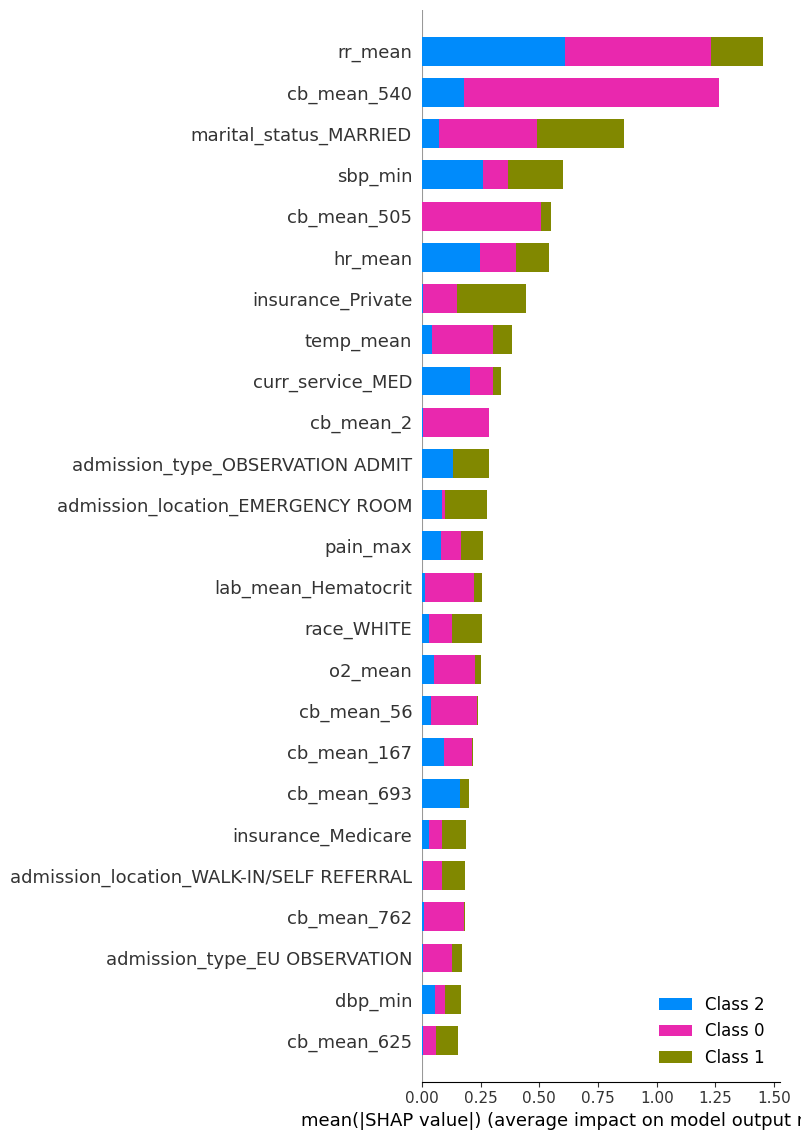

In [22]:
# Phase5_11_4: Global SHAP summary plot (all classes)

import shap
import matplotlib.pyplot as plt

# Make sure we use the corrected list-of-arrays format

shap.summary_plot(
    shap_values_corrected,
    X_test,
    feature_names=feature_names,
    max_display=25
)


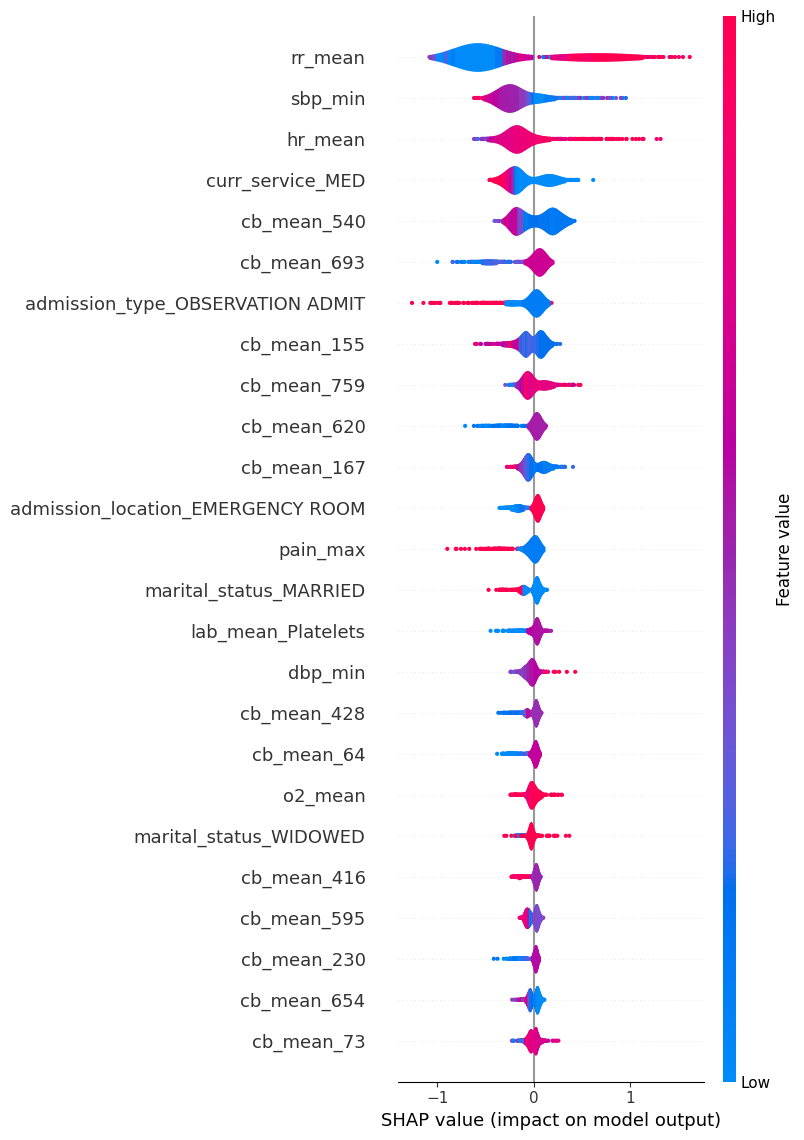

In [23]:
# Phase5_11_5: SHAP summary plot for CRITICAL class (class 2)

critical_class_index = 2  # 0=Low, 1=Moderate, 2=Critical

shap.summary_plot(
    shap_values_corrected[critical_class_index],
    X_test,
    feature_names=feature_names,
    max_display=25,
    plot_type="violin"  # beeswarm-style per-feature distribution
)


This plot shows which features push the model toward predicting a patient as Critical. High respiratory rate, low blood pressure, high heart rate, and low oxygen levels strongly increase Critical risk. Some ClinicalBERT embedding features also contribute, meaning the model picks up severe-symptom language from notes. Overall, abnormal vitals + certain text features are the main drivers of Critical predictions.

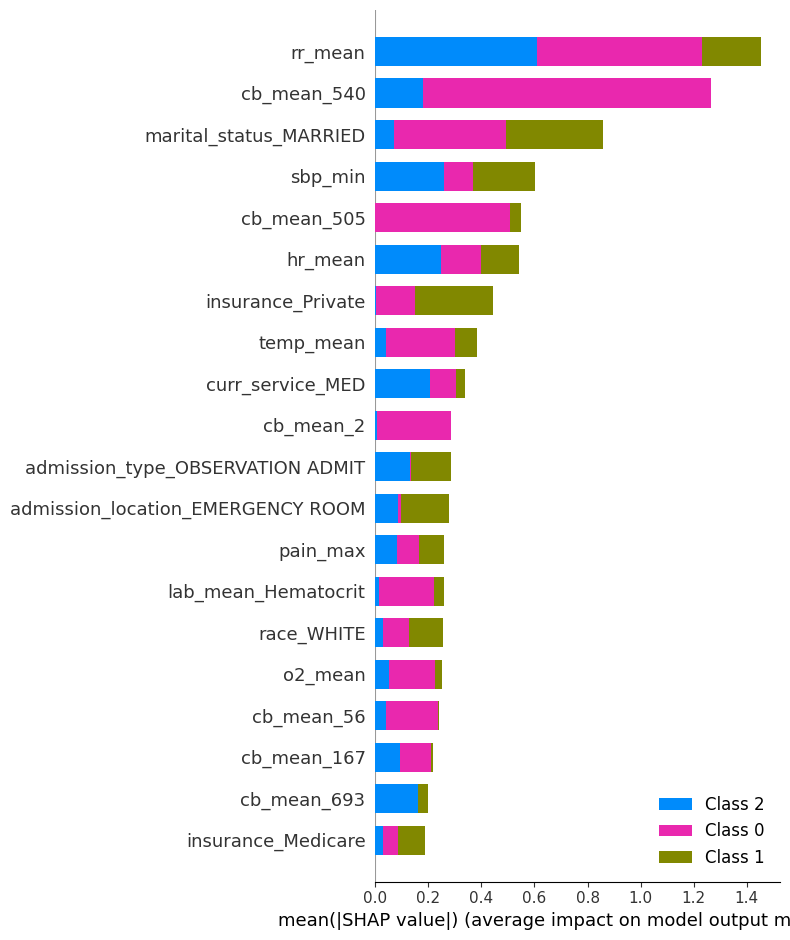

In [24]:
# Phase5_11_6: SHAP bar plot of top 20 most important features

shap.summary_plot(
    shap_values_corrected,     # the corrected per-class list
    X_test,
    feature_names=feature_names,
    plot_type="bar",
    max_display=20
)


The SHAP bar plot shows the top features that influence the triage model across all classes. Respiratory rate (rr_mean), systolic blood pressure (sbp_min), heart rate (hr_mean), and temperature (temp_mean) are the most important vitals. Several ClinicalBERT embedding dimensions also appear, meaning the model uses both note text and structured vitals to determine urgency. Admission-related fields (like admission type or location) and some lab features also contribute, but to a lesser extent.